In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_style('darkgrid')
from itertools import product
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'monospace'
from IPython.display import display

In [3]:
from data_analysis import *

# data loading

1. `scores` includes flat `best_algorithm_` and the refitted `best_algorithm_`s from `ncv_*`.
  - from `'d_scores_complete.csv'`
  - The main purpose is to provide a comparison of FlatCV vs NestedCV
  - for generic plotting
    - general overview
    - boxplots
    - performance heatmaps
2. `feature_sets`'
  - to plot out radiomic signature heatmaps
3. `cv_results_`
  - hyperparameters reside here
  - to plot n_features vs performance
  - **_caveat_**: it is not actual n_features...

In [7]:
scores, feature_sets = load_data()

/home/bee/.anaconda3/envs/rfs/lib/python3.8/site-packages/pandas/core/generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/bee/.anaconda3/envs/rfs/lib/python3.8/site-packages/pandas/core/generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


# freestyle

## NestedCV vs FlatCV for algorithm choice

Firstly, we'll assess the percentage of times that NestedCV and FlatCV agree on the #1 algorithm.

In [5]:
cmetric = 'kappa'
experimental_dims = scores.index.names[:-1]

# ncv
ncv = scores[[(cmetric, 'ncv_val')]]
gb = ncv.groupby(experimental_dims)
ncv = gb.agg(['mean', 'std']).droplevel(1, axis=1)
ncv.columns.names = ['metric', 'st']
ncv['performance_estimator'] = 'nestedcv'
ncv = (
    ncv
    .set_index('performance_estimator', append=True)
    .droplevel('metric', axis=1)
    .unstack('performance_estimator')
    .swaplevel(axis=1)
)

# flt
flt = scores[[(cmetric, 'cv_mean'), (cmetric, 'cv_std')]].reset_index('model')
flt = (
    flt.loc[flt['model'] == 'flat']
    .rename(columns={'model':'performance_estimator'})
    .set_index('performance_estimator', append=True)
    .unstack('performance_estimator')
    .droplevel('metric', axis=1)
    .rename(lambda s: s.replace('cv_', ''), axis=1)
    .rename(lambda s: s.replace('flat', 'flatcv'), axis=1)
    .swaplevel(axis=1)
)
experimental_dims = experimental_dims[:-1]

def ranker(group):
    src = group.columns.levels[0][0]
    g = (
        group
        .sort_values([(src, st) for st in ['mean', 'std']], ascending=[False, True])
    )
    g[(src, 'rank')] = pd.Series(np.arange(1, g.shape[0]+1), index=g.index)
    g = g.reset_index('algorithm').set_index('algorithm')
    return g
    
ncv = ncv.groupby(experimental_dims).apply(ranker)
flt = flt.groupby(experimental_dims).apply(ranker)
ranked = flt.join(ncv)
# del cmetric, flt, ncv
ranked.head(7)

performance_estimator                                                     flatcv  \
st                                                                          mean   
dataset[feat_range] as_cv_step fs_method       incl_filtered algorithm             
abus[3-15-1]        False      boruta_lightgbm False         nb         0.509655   
                                                             mlp        0.508541   
                                                             svm        0.508541   
                                                             gbc        0.491184   
                                                             rf         0.474517   
                                                             knn        0.456494   
                                                             lr         0.390869   

performance_estimator                                                             \
st                                                                           std   
dataset[feat_range] as_cv_step fs_method       incl_filtered algorithm             
abus[3-15-1]        False      boruta_lightgbm False         nb         0.224294   
                                                             mlp        0.225688   
                                                             svm        0.225688   
                                                             gbc        0.196810   
                                                             rf         0.190482   
                                                             knn        0.217440   
                                                             lr         0.158742   

performance_estimator                                                        \
st                                                                     rank   
dataset[feat_range] as_cv_step fs_method       incl_filtered algorithm        
abus[3-15-1]        False      boruta_lightgbm False         nb           1   
                                                             mlp          2   
                                                             svm          3   
                                                             gbc          4   
                                                             rf           5   
                                                             knn          6   
                                                             lr           7   

performance_estimator                                                   nestedcv  \
st                                                                          mean   
dataset[feat_range] as_cv_step fs_method       incl_filtered algorithm             
abus[3-15-1]        False      boruta_lightgbm False         nb         0.492989   
                                                             mlp        0.491202   
                                                             svm        0.491184   
                                                             gbc        0.456760   
                                                             rf         0.474517   
                                                             knn        0.473010   
                                                             lr         0.407705   

performance_estimator                                                             \
st                                                                           std   
dataset[feat_range] as_cv_step fs_method       incl_filtered algorithm             
abus[3-15-1]        False      boruta_lightgbm False         nb         0.220515   
                                                             mlp        0.249582   
                                                             svm        0.196810   
                                                             gbc        0.161800   
                                                             rf         0.190482   
              

In [14]:
rectal = ranked.loc['rectal[3-15-1]'].groupby(['as_cv_step', 'incl_filtered', 'algorithm'])[[(cv, 'rank') for cv in ['flatcv', 'nestedcv']]].mean().loc[True].loc[False].sort_values(('nestedcv', 'rank'))

sorter = ('flatcv', 'rank')
rectal.sort_values(sorter)[[sorter]]

performance_estimator,flatcv
st,rank
algorithm,
svm,1.2
knn,2.4
mlp,4.0
lr,4.6
gbc,5.0
nb,5.2
rf,5.6


In [20]:
# indifferent to as_cv_step, so it is excluded from groupby
not_rectal = ranked.drop('rectal[3-15-1]').groupby(['dataset[feat_range]', 'incl_filtered', 'algorithm'])[[(cv, 'rank') for cv in ['flatcv', 'nestedcv']]].mean()

ranked_by = ('flatcv', 'rank')
ranked_by = ('nestedcv', 'rank')
# dataset = 'abus[3-15-1]'
# dataset = 'pancreatic[3-15-1]'
dataset = 'pancreatic[5-40-5]'

not_rectal.loc[dataset, False].sort_values(ranked_by)[[ranked_by]]

performance_estimator,nestedcv
st,rank
algorithm,
svm,2.4
rf,2.7
gbc,3.3
lr,3.3
nb,5.2
knn,5.3
mlp,5.8


In [6]:
from scipy.stats import kendalltau


def equal_first_place(group):
    global a
    a = group.reset_index('algorithm')
    res = a.loc[a['flatcv'] == 1, 'algorithm'] \
        == a.loc[a['nestedcv'] == 1, 'algorithm']
    res = res.values[0]
    return res

def choices(group):
    a = group.reset_index('algorithm')
    return a.loc[a['nestedcv'] == 1, 'algorithm'].values[0], a.loc[a['flatcv'] == 1, 'algorithm'].values[0]

def equal_top_set(group, topn=3):
    pass

def rank_analyzer(group):
    kt = kendalltau(group['flatcv'], group['nestedcv'])
    efp = equal_first_place(group)
    ncv_choice, flatcv_choice = choices(group)
    return pd.Series(
        [kt.correlation, kt.pvalue, efp, ncv_choice, flatcv_choice],
        index=['tau', 'pval', 'equal_first_place', 'ncv_choice', 'flatcv_choice']
    )


gb = ranked.swaplevel(axis=1)['rank'].groupby(experimental_dims)
ranked_analyzed = gb.apply(rank_analyzer)

In [7]:
ranked_analyzed[ranked_analyzed.pval < .05].loc[order_dataset_frange].drop('equal_first_place', axis=1)

tau  \
dataset[feat_range] as_cv_step fs_method       incl_filtered             
rectal[3-15-1]      False      boruta_lightgbm False          0.809524   
                               kbest_mi        True           0.714286   
abus[3-15-1]        False      boruta_lightgbm False          0.809524   
                               boruta_rf       True           0.714286   
                               lasso           True           0.809524   
                               rfe_lasso       False          0.714286   
                    True       kbest_mi        True           0.714286   
                               lasso           False          0.714286   
pancreatic[3-15-1]  False      boruta_rf       False          0.904762   
                               kbest_mi        False          0.714286   
                               lasso           False          0.904762   
                                               True           0.714286   
                               rfe_lasso       False          0.809524   
                                               True           0.714286   
pancreatic[5-40-5]  False      kbest_mi        True           0.714286   
                               lasso           True           0.714286   
                               rfe_lasso       True           0.904762   
                    True       boruta_rf       False          0.714286   
                                               True           0.809524   

                                                                  pval  \
dataset[feat_range] as_cv_step fs_method       incl_filtered             
rectal[3-15-1]      False      boruta_lightgbm False          0.010714   
                               kbest_mi        True           0.030159   
abus[3-15-1]        False      boruta_lightgbm False          0.010714   
                               boruta_rf       True           0.030159   
                               lasso           True           0.010714   
                               rfe_lasso       False          0.030159   
                    True       kbest_mi        True           0.030159   
                               lasso           False          0.030159   
pancreatic[3-15-1]  False      boruta_rf       False          0.002778   
                               kbest_mi        False          0.030159   
                               lasso           False          0.002778   
                                               True           0.030159   
                               rfe_lasso       False          0.010714   
                                               True           0.030159   
pancreatic[5-40-5]  False      kbest_mi        True           0.030159   
                               lasso           True           0.030159   
                               rfe_lasso       True           0.002778   
                    True       boruta_rf       False          0.030159   
                                               True           0.010714   

                                                             ncv_choice  \
dataset[feat_range] as_cv_step fs_method       incl_filtered              
rectal[3-15-1]      False      boruta_lightgbm False                svm   
                               kbest_mi        True                 gbc   
abus[3-15-1]        False      boruta_lightgbm False                 nb   
                               boruta_rf       True                 gbc   
                               lasso           True                  lr   
                               rfe_lasso       False                svm   
                    True       kbest_mi        True                  lr   
                               lasso           False                mlp   
pancreatic[3-15-1]  False      boruta_rf       False                gbc   
                               kbest_mi        False                svm   
                               lasso           False     

## best of the best per dataset

In [17]:
def filterer(group, metric=('kappa', 'test'), topn=5):
    global g
    g = group
    g = group.sort_values(by=metric, ascending=False).head(topn).droplevel(0)
    return g[[(m, n) for m, n in product((metric[0],), ('test', 'cv_mean', 'ncv_val'))]].join(g['n_features[actual]'])

gb = scores.groupby('dataset[feat_range]')
top = gb.apply(filterer).loc[order_dataset_frange]
top.join(ranked_analyzed[['flatcv_choice', 'ncv_choice']]).loc[order_dataset_frange].reset_index(['algorithm', 'model'])#.drop('n_features[actual]', axis=1)

algorithm  model  \
dataset[feat_range] as_cv_step fs_method       incl_filtered                    
rectal[3-15-1]      True       lasso           False               mlp  ncv_2   
                                               False                lr  ncv_2   
                                               False                lr  ncv_1   
                               rfe_lasso       False                lr  ncv_2   
                                               False               mlp   flat   
abus[3-15-1]        False      kbest_mi        True                gbc  ncv_2   
                                               True                gbc  ncv_1   
                                               True                gbc  ncv_4   
                    True       boruta_lightgbm True                knn  ncv_1   
                               kbest_mi        True                gbc  ncv_4   
pancreatic[3-15-1]  False      lasso           True                svm  ncv_1   
                               rfe_lasso       True                svm  ncv_1   
                                               True                svm  ncv_3   
                                               True                svm  ncv_4   
                    True       rfe_lasso       True                 rf  ncv_1   
pancreatic[5-40-5]  False      lasso           True                svm  ncv_3   
                                               True                svm  ncv_0   
                               rfe_lasso       True                svm  ncv_3   
                                               True                svm  ncv_0   
                    True       lasso           True                 rf   flat   

                                                              (kappa, test)  \
dataset[feat_range] as_cv_step fs_method       incl_filtered                  
rectal[3-15-1]      True       lasso           False               0.784091   
                                               False               0.784091   
                                               False               0.784091   
                               rfe_lasso       False               0.784091   
                                               False               0.784091   
abus[3-15-1]        False      kbest_mi        True                0.577338   
                                               True                0.531278   
                                               True                0.531278   
                    True       boruta_lightgbm True                0.498221   
                               kbest_mi        True                0.533814   
pancreatic[3-15-1]  False      lasso           True                0.382276   
                               rfe_lasso       True                0.382276   
                                               True                0.382276   
                                               True                0.382276   
                    True       rfe_lasso       True                0.384858   
pancreatic[5-40-5]  False      lasso           True                0.382276   
                                               True                0.382276   
                               rfe_lasso       True                0.382276   
                                               True                0.382276   
                    True       lasso           True                0.353312   

                                                              (kappa, cv_mean)  \
dataset[feat_range] as_cv_step fs_method       incl_filtered                     
rectal[3-15-1]      True       lasso           False                  0.073427   
                                               False                  0.022145   
                                               False                  0.022145   
                               rfe_lasso       False                  0.022145   
                                               

# scores / generic plot

In [108]:
from scipy.stats import shapiro, ttest_ind, ttest_rel, wilcoxon
from itertools import combinations_with_replacement


order_fs_method = ['lasso', 'rfe_lasso', 'kbest_mi', 'boruta_rf', 'boruta_lightgbm']
order_cvmode = ['flat', 'nested_mean']
order_dataset   = ['rectal', 'abus', 'pancreatic']

order_dataset_feat_range = ['rectal[3-15-1]', 'abus[3-15-1]', 'pancreatic[3-15-1]', 'pancreatic[5-40-5]']
order_fs_method_cvmode = [f'{i}[{j}]'for i, j in product(order_fs_method, order_cvmode)]

order_dataset_feat_range__fs_method = list(product(
    order_dataset_feat_range,
    order_fs_method
))


dataset_selector = widgets.SelectMultiple(
    options=order_dataset_feat_range,
    value=order_dataset_feat_range,
    description='Select datasets',
    disabled=False
)

def hl_significant(val):
    '''
    highlight the maximum in a Series yellow.
    '''
    color = 'background-color: #33cc9e' if val < .05 else ''
    return color


@interact(
    x   = ['dataset[feat_range]', 'dataset[feat_range][fs_method]', 'fs_method', 'as_cv_step', 'incl_filtered', 'algorithm', 'undersample'],
    hue = ['fs_method', 'dataset[feat_range]', 'as_cv_step', 'incl_filtered', 'algorithm', 'undersample'],
    as_cv_step    = [True, 'both', False],
    incl_filtered = [False, 'both', True],
    
    metric = ['kappa', 'roc_auc', 'n_features[actual]'],
    stat   = ['test', 'cv_mean', 'diff', 'cv_std', 'ncv_val', 'ncv_diff'],
    model    = ['all', 'flat vs. nested', 'flat', 'ncv'],
    dataset = dataset_selector,

    plotter = [sns_barplot, sns_boxplot, sns_stripplot],
    rotate_xticks = False
)
def ino(x, hue, as_cv_step, incl_filtered, metric, stat, model, dataset, plotter, rotate_xticks):

    global d, testies

    d = scores

    # metric and stat selection off the start
    if metric != 'n_features[actual]':
        d = d[(metric, stat)].reset_index().droplevel(1, axis=1)
    else:
        d = d[metric].reset_index()
    # proper ordering for easy reading
    d = (
        d.set_index(['dataset[feat_range]', 'fs_method'])
        .loc[order_dataset_feat_range__fs_method]
    )
    
    # selecte datasets....
    d = d.loc[list(dataset)].reset_index()
    
    
    # slice data & add to the title
    condition = np.array([True] * d.shape[0])
    axes_title = f'{metric} :: {stat}'
    if model == 'flat':
        axes_title += ' :: FlatCV'
    elif model == 'ncv':
        axes_title += ' :: NestedCV'
    axes_title += '\n'

    if as_cv_step != 'both' and x != 'as_cv_step':
        condition = ((condition) & (d['as_cv_step'] == as_cv_step))

        axes_title += f'\n{"feature selection mode: "}'
        axes_title += (
            'as pipeline cv-step' if as_cv_step
            else 'as preprocessing step'
        )

    if incl_filtered != 'both' and x != 'incl_filtered':
        condition = ((condition) & (d['incl_filtered'] == incl_filtered))
        
        axes_title += f'\n{"initial feature set: "}'
        axes_title += (
            'original features' if not incl_filtered
            else 'original + filtered features'
        )
    
    if len(dataset) != 4 and x != 'dataset[feat_range]':        
        axes_title += f'\ndatasets: {[da for da in dataset]}'

    d = d[condition]

    if model == 'flat vs. nested':

        # get a new slicing strategy: aggregate nested into mean
        df = d[d.model == 'flat']
        dn = d[d.model != 'flat'].groupby(list(d.columns[:-2]))[[metric]].mean().reset_index()
        dn['model'] = 'nested_mean'
        d = df.append(dn).rename(columns={'model': 'cvmode'})

        # append cvmode (created just above) to the hue categories
        hue_ = f'{hue}[cvmode]'
        d[hue_] = d[hue].astype(str) + '[' + d['cvmode'] + ']'

        ax = plotter(
            data=d,
            x=x,
            y=metric,
            hue=hue_,
            figsize=(10, 4),
            hue_order=order_fs_method_cvmode if hue == 'fs_method' else None
        ); ax.legend(loc='upper left', bbox_to_anchor=(1, 1.02), title=hue_)
#         ax.set_title(axes_title)
        if rotate_xticks:
            ax.tick_params(axis='x', labelrotation=90)

        def testies(group):
            group = group.set_index('cvmode')[metric]
            return pd.Series({
                'shapiro_flat': shapiro(group['flat']).pvalue,
                'shapiro_nested_mean': shapiro(group['nested_mean']).pvalue,
                'ttest_rel': ttest_rel(
                    group['flat'], group['nested_mean'],
                    alternative='greater'
                ).pvalue,
                'wilcoxon': wilcoxon(
                    group['flat'], group['nested_mean'],
                    alternative='greater'
                ).pvalue
            })

        tests = d.groupby([x, hue]).apply(testies).round(6)
        if x == 'dataset[feat_range]':
            ox = order_dataset_feat_range
            if hue == 'fs_method':
                oh = order_fs_method
                return tests.loc[list(product(ox, oh))].style.applymap(hl_significant)
        elif x == 'fs_method':
            ox = order_fs_method
            if hue == 'dataset[feat_range]':
                oh = order_dataset_feat_range
                return tests.loc[list(product(ox, oh))].style.applymap(hl_significant)

        tests = tests.dropna(how='all').dropna(how='all', axis=1)
        return tests.style.applymap(hl_significant)

    else:

        if model == 'flat':
            d = d[d.model == 'flat']
        elif model == 'ncv':
            d = d[d.model != 'flat']

        hue_order = order_fs_method if hue == 'fs_method' else None
        hue_order = order_dataset_feat_range if hue == 'dataset[feat_range]' else hue_order
            
        ax = plotter(
            data=d,
            x=x,
            y=metric,
            hue=hue,
            figsize=(10, 4),
            hue_order=hue_order
        )
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1.02), title=hue)
        ax.get_legend().remove()
#         ax.set_title(axes_title)
        if rotate_xticks:
            ax.tick_params(axis='x', labelrotation=90)
        
        def test_hue_differences(df, hue, metric):
            cats = df[hue].unique()
            g = df.set_index(hue)
            wilcox_df = pd.DataFrame(index=cats, columns=cats)
            for cat1, cat2 in filter(lambda t: t[0] != t[1], combinations_with_replacement(cats, 2)):     
                wilcox_df.loc[cat1, cat2] = wilcoxon(g.loc[cat1, metric], g.loc[cat2, metric]).pvalue
            return wilcox_df
        
        testies = d.groupby(x).apply(test_hue_differences, hue, metric).round(6)
        if x == 'dataset[feat_range]':
            testies = testies.loc[set(order_dataset_feat_range).intersection(dataset)]
        testies = testies.dropna(how='all').dropna(how='all', axis=1)

        pd.set_option("display.precision", 6)
        display(testies)


interactive(children=(Dropdown(description='x', options=('dataset[feat_range]', 'dataset[feat_range][fs_method…

# Effect of the number of features on the test set performance

coef        R2          F      pval
ds                 fsm                                                     
abus[3-15-1]       boruta_lightgbm  0.049609  0.351141  44.375594  0.000000
                   lasso            0.019479  0.380059  50.270580  0.000000
pancreatic[3-15-1] lasso            0.012081  0.357421  45.610687  0.000000
                   rfe_lasso        0.011127  0.283552  32.453497  0.000000
pancreatic[5-40-5] kbest_mi         0.002873  0.150141  14.486586  0.000271
                   lasso            0.001944  0.064528   5.656321  0.019718

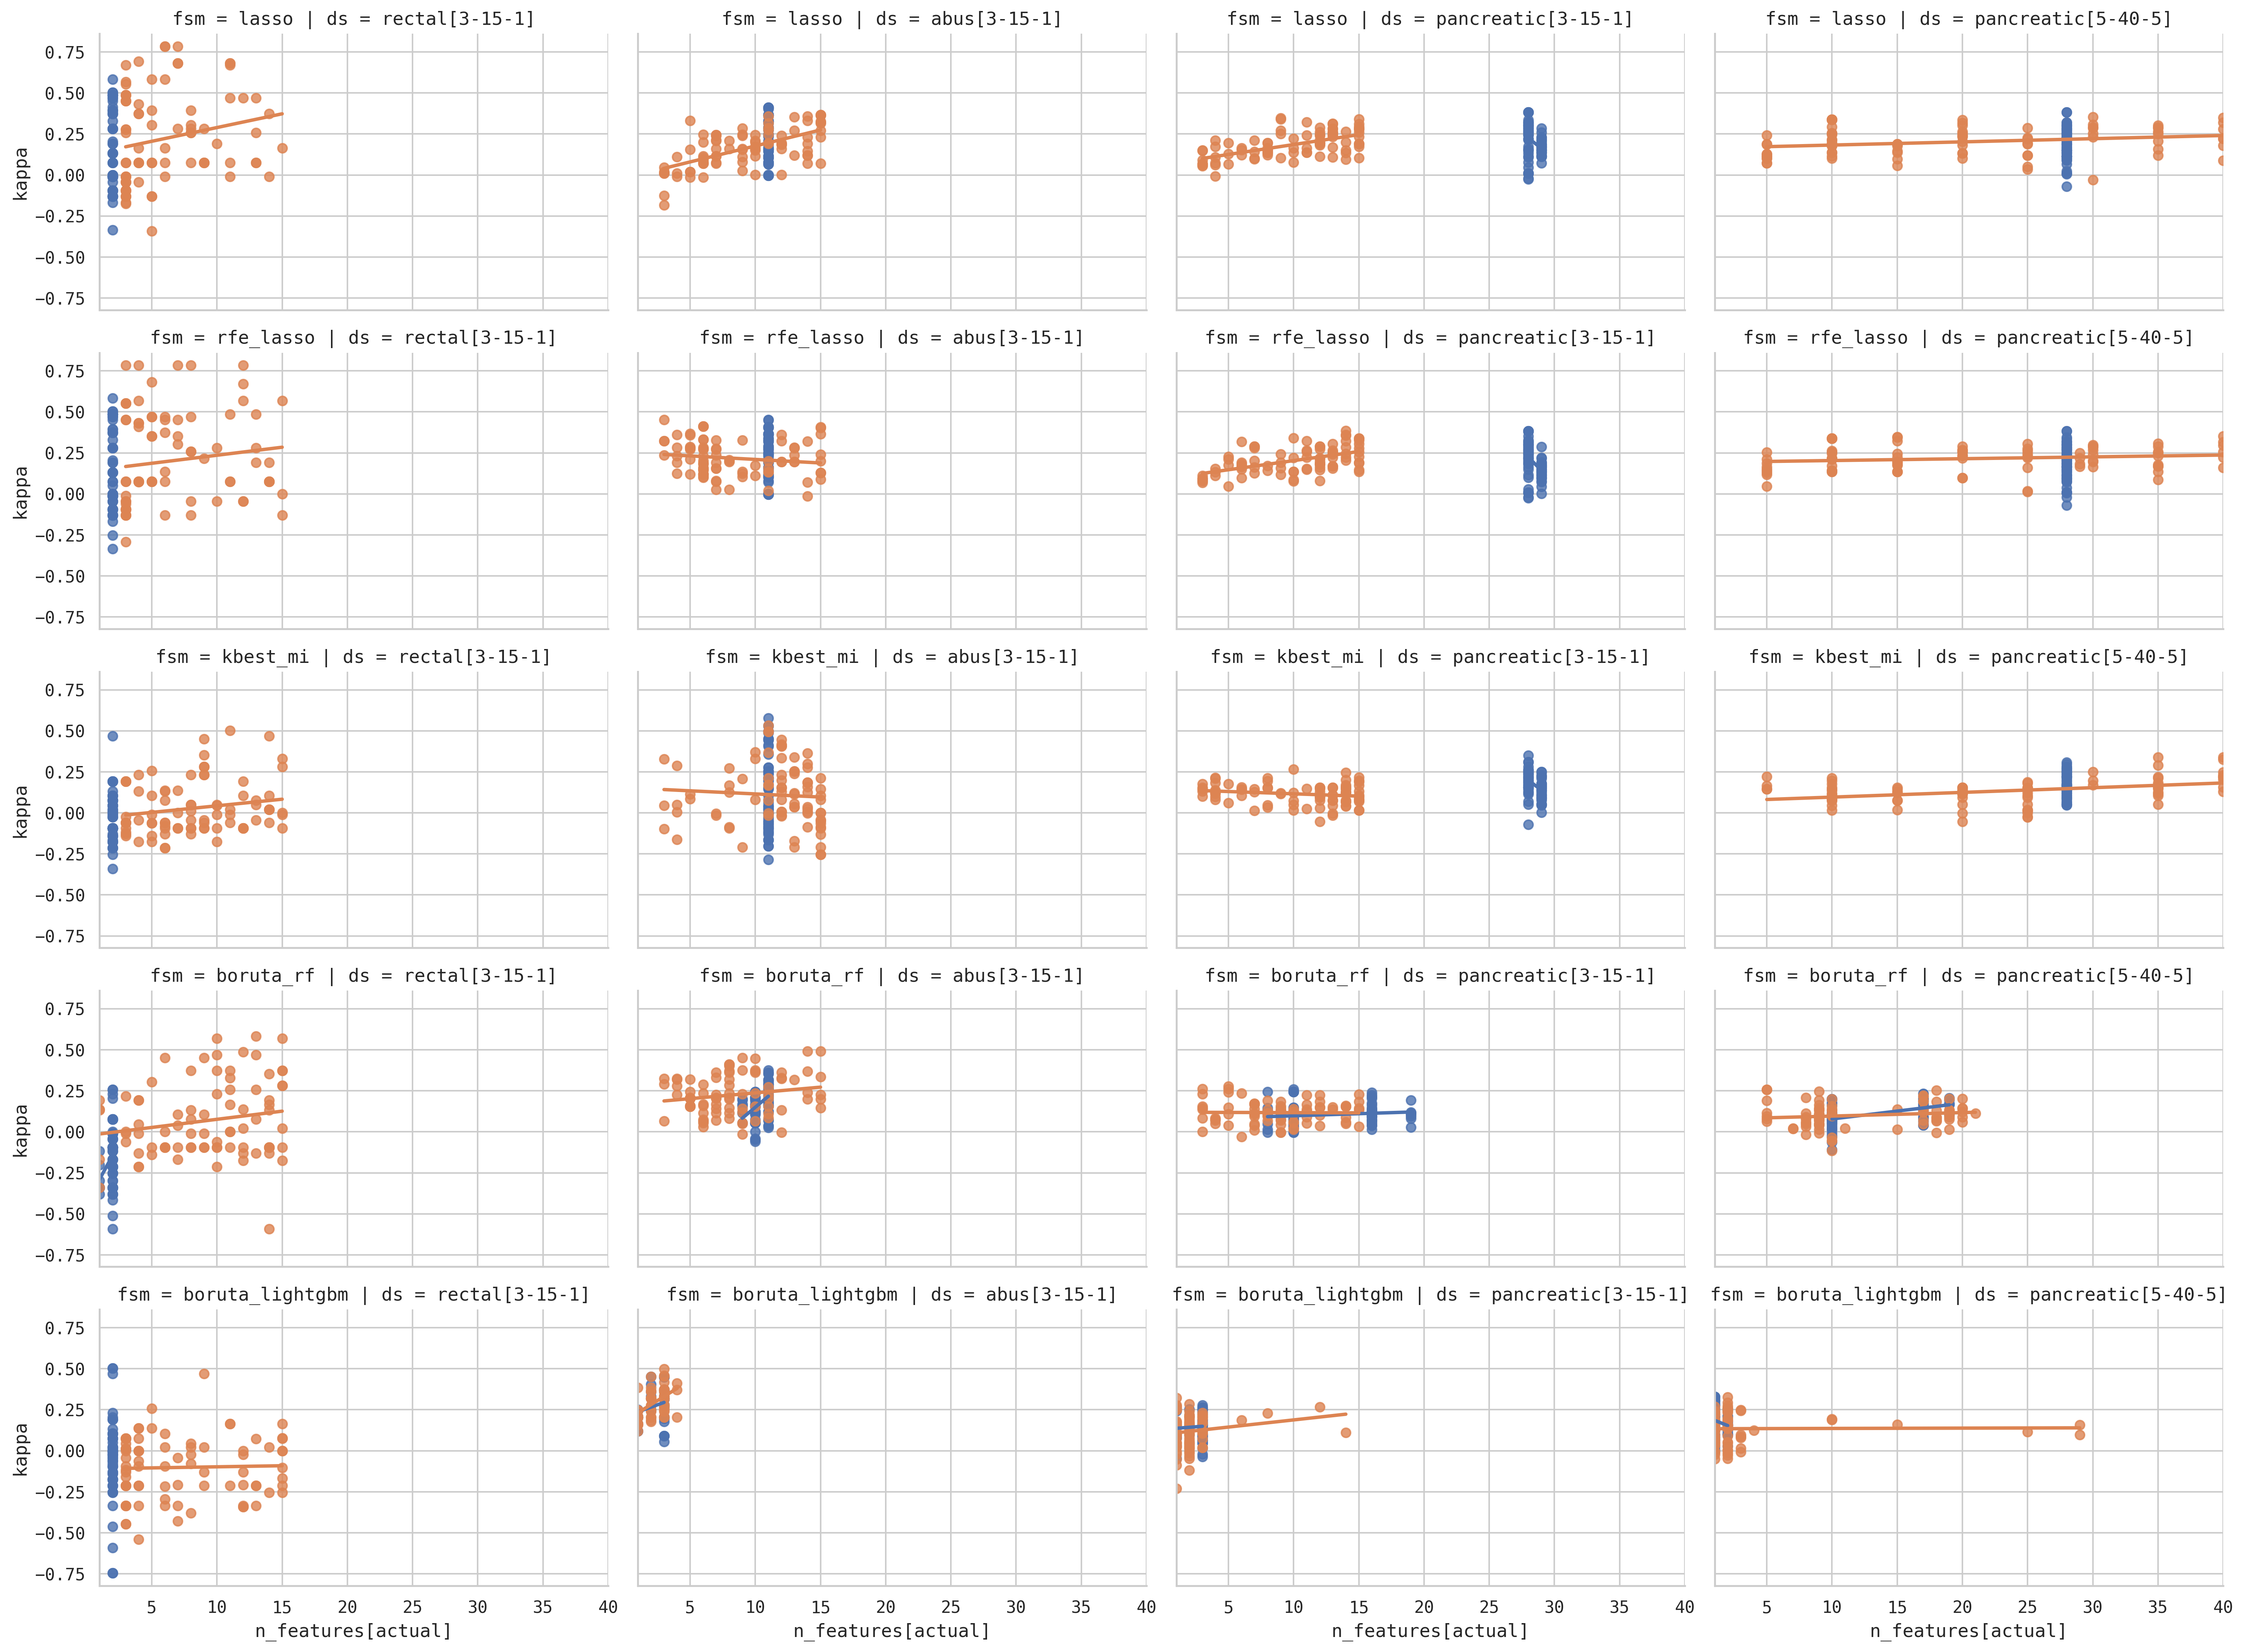

In [8]:
from seaborn import displot, lmplot
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression

d = (
    scores
        .set_index('n_features[actual]', append=True)[[('kappa', 'test'), ('roc_auc', 'test')]]
        .droplevel(1, 1).reset_index()
        .set_index(['dataset[feat_range]', 'fs_method'])#.loc[order_dataset_feat_range__fs_method]
        .reset_index().rename(columns={'dataset[feat_range]':'ds', 'fs_method':'fsm'})
#         .set_index('as_cv_step').loc[True]
#         .set_index('incl_filtered').loc[False]
#         .set_index('algorithm').loc['rf']
)

fgrid = lmplot(
    data = d.set_index(['ds', 'fsm']).loc[order_dataset_feat_range__fs_method].reset_index(),
    x = 'n_features[actual]',
    row = 'fsm', col = 'ds', legend=False,
    y = 'kappa',
    hue='as_cv_step',
    aspect = 1.7, height=3,
    ci=None
)


def f_test(group):
    x = group[['n_features[actual]']]
    y = group['kappa']
    lr = LinearRegression().fit(x, y)
    r2 = lr.score(x, y)
    coef = lr.coef_[0]
    
    f, pval = f_regression(x, y)
    f = f[0]; pval = pval[0]
    
    return pd.Series([coef, r2, f, pval], index=['coef', 'R2', 'F', 'pval'])


def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_significant = s < .05
    return ['background-color: #33cc9e' if v else '' for v in is_significant]

gb = d.set_index('as_cv_step').loc[True].groupby(['ds', 'fsm'])[['n_features[actual]', 'kappa']]
f = gb.apply(f_test)#.loc[order_dataset_feat_range__fs_method]
f.loc[:, 'pval'] = f['pval'].round(6)
f.loc[f.pval < .05]#.style.apply(highlight_max, subset='pval')
# f

# Additional material

## performance heatmaps - `fs_method` vs `algorithm`

In [112]:
from scipy.stats import shapiro, ttest_ind, ttest_rel, wilcoxon
from itertools import combinations_with_replacement


order_fs_method = ['lasso', 'rfe_lasso', 'kbest_mi', 'boruta_rf', 'boruta_lightgbm']
order_cvmode = ['flat', 'nested_mean']
order_dataset   = ['rectal', 'abus', 'pancreatic']

order_dataset_feat_range = ['rectal[3-15-1]', 'abus[3-15-1]', 'pancreatic[3-15-1]', 'pancreatic[5-40-5]']
order_fs_method_cvmode = [f'{i}[{j}]'for i, j in product(order_fs_method, order_cvmode)]

order_dataset_feat_range__fs_method = list(product(
    order_dataset_feat_range,
    order_fs_method
))

order_algorithm = ['nb', 'knn', 'rf', 'svm', 'mlp', 'gbc', 'lr']

def hl_significant(val):
    '''
    highlight the maximum in a Series yellow.
    '''
    color = 'background-color: #33cc9e' if val < .05 else ''
    return color


@interact(
    x   = ['algorithm', 'fs_method', 'as_cv_step', 'incl_filtered', 'undersample'],
    y = ['fs_method', 'as_cv_step', 'incl_filtered', 'algorithm', 'undersample'],
    as_cv_step    = [True, 'both', False],
    incl_filtered = [False, 'both', True],
    
    metric = ['kappa', 'roc_auc'],
    stat   = ['test', 'mean', 'diff', 'std', 'ncv_val', 'ncv_diff'],
    algorithm    = ['all', 'flat', 'ncv'],
    dataset = order_dataset_feat_range
)
def ino(x, y, as_cv_step, incl_filtered, metric, stat, algorithm, dataset):
    global d
    
    # metric and stat selection off the start
    d = scores[(metric, stat)].reset_index().droplevel(1, axis=1)
    # proper ordering for easy reading
    d = (
        d.set_index(['dataset[feat_range]', 'fs_method'])
        .loc[order_dataset_feat_range__fs_method].reset_index()
    )    
    
    # slice data & add to the title
    condition = np.array([True] * d.shape[0])
    axes_title = f'{metric} :: {stat}'
    if algorithm == 'flat':
        axes_title += ' :: FlatCV'
    elif algorithm == 'ncv':
        axes_title += ' :: NestedCV'
    axes_title += '\n'
    sufftitle = ''
    
    if as_cv_step != 'both' and x != 'as_cv_step':
        condition = ((condition) & (d['as_cv_step'] == as_cv_step))

        axes_title += f'\n{"feature selection mode: "}'
        axes_title += (
            'as pipeline cv-step' if as_cv_step
            else 'as preprocessing step'
        )
        sufftitle += f'\n{"feature selection mode: "}'
        sufftitle += (
            'as pipeline cv-step' if as_cv_step
            else 'as preprocessing step'
        )

    if incl_filtered != 'both' and x != 'incl_filtered':
        condition = ((condition) & (d['incl_filtered'] == incl_filtered))
        
        axes_title += f'\n{"initial feature set: "}'
        axes_title += (
            'original features' if not incl_filtered
            else 'original + filtered features'
        )
        sufftitle += f'\n{"initial feature set: "}'
        sufftitle += (
            'original features' if not incl_filtered
            else 'original + filtered features'
        )

    d = d[condition]
    
    global plotting_data
    plotting_data = None

    if algorithm == 'flat':
        d = d[d.algorithm == 'flat']
    elif algorithm == 'ncv':
        d = d[d.algorithm != 'flat']


    plotting_data = pd.pivot_table(d, index=['dataset[feat_range]', x], columns=y, values=metric, aggfunc='median')

    # misc ordering
    if y == 'fs_method':
        plotting_data = plotting_data[order_fs_method]

    if x == 'algorithm':
        o = list(product(order_dataset_feat_range, order_algorithm))
        plotting_data = plotting_data.loc[o]
    
    ny, nx = plotting_data.shape  # number of entries in each axis
    fig, axes = plt.subplots(figsize=(.3*ny, 3 + .3*nx), sharey=True)
#     fig.suptitle(axes_title)

    sns.heatmap(
        plotting_data.loc[dataset].transpose(),
        cmap=sns.cubehelix_palette(n_colors=50, reverse=True),
        annot=True,
        fmt='.3f',  # this rounds the values :'(
        ax=axes,
        linewidth=.3,
        linecolor='white'
    )
    axes.set_title(f'{dataset}{sufftitle}')
    plt.yticks(rotation=0)
    fig.tight_layout()


interactive(children=(Dropdown(description='x', options=('algorithm', 'fs_method', 'as_cv_step', 'incl_filtere…

## feature sets / radiomic signatures (fix)

In [110]:
def topf(df, topn=3):
    return df.transpose().iloc[:, 0].nlargest(topn)

@interact(
    dataset=order_dataset_feat_range,
    algorithm=widgets.SelectMultiple(options=['ncv', 'flat', 'outer'], rows=3, value=['ncv', 'flat'])
)
def iplot(dataset, algorithm):

    global fsr
    """
    fsr: calculating percentages ('feature sets relative')
    """
    fsr = (
        feature_sets.reset_index()
    )
    # selecting the source...
    bidx = fsr.algorithm.map(lambda s: any([sr in s for sr in algorithm]))
    fsr = (
        # slicing to selected sources
        fsr.loc[bidx]
        # as_cv_step is only True
        # and we want the percentages from across all algorithms and selected sources
        .drop(['as_cv_step', 'algorithm', 'algorithm'], axis=1)
        # percentage calculation
        .groupby(['dataset[feat_range]', 'fs_method', 'incl_filtered'])
        .agg(lambda df: df.count() / df.shape[0])
        # reordering and reindexing
        .reset_index(['incl_filtered'])
        .loc[order_dataset_feat_range__fs_method]
        .set_index(['incl_filtered'], append=True)
    )
    
    """
    tops: plotting data for the heatmaps
    """
    tops = fsr.groupby(['dataset[feat_range]', 'fs_method', 'incl_filtered']).apply(topf).unstack('feature')
    tops = tops.loc[dataset]
    tops = tops.loc[:, (tops.notna().any())].transpose().sort_index()[[
        'lasso', 'rfe_lasso', 'kbest_mi', 'boruta_rf', 'boruta_lightgbm'
    ]]
    
    original_filter = lambda s: 'original' in s
    filtered_filter = lambda s: 'original' not in s

    cols = list(product((False, True), ('lasso', 'rfe_lasso', 'kbest_mi', 'boruta_rf', 'boruta_lightgbm')))

    tops = (
        tops
        .loc[
            sorted(list(filter(filtered_filter, tops.index)))
            + sorted(list(filter(original_filter, tops.index)))
        ]
        .swaplevel(axis=1)[cols]
    )

    tops.columns = tops.columns.set_levels(tops.columns.levels[0].map(lambda b: '[orgnl+fltr]' if b else '[orgnl]'), level=0)
    tops.columns = tops.columns.set_levels(tops.columns.levels[1].map(lambda s: f'{s}'), level=1)
    tops.columns.names = ['initial feature set ', ' feature selection method']
    
    nx, ny = tops.shape  # number of entries in each axis
    fig, ax = plt.subplots(figsize=(.9*ny, 2 + .4*nx))
    title_cv_mode = ''; cvm_map = {'flat': 'FlatCV', 'ncv':'NestedCV', 'outer':'outer'}
    for source in algorithm:
        title_cv_mode += f' {cvm_map[source]}'
    ax.set_title(f'Top 3 from {dataset} :: {title_cv_mode}')
    sns.set_style('darkgrid')
    sns.heatmap(
        tops,
        cmap=sns.cubehelix_palette(n_colors=50, reverse=True),
        annot=True,
        fmt='.3f',  # this rounds the values :'(
        ax=ax,
        linewidth=.3
    )    


interactive(children=(Dropdown(description='dataset', options=('rectal[3-15-1]', 'abus[3-15-1]', 'pancreatic[3…